# Importing libraries

In [1]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Importing data

In [2]:
def load_video_paths_and_labels(dataset_dir):
    video_paths = []
    labels = []

    class_map = {
        'non shop lifters': 0,
        'shop lifters': 1
    }

    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        
        for file in glob(os.path.join(class_dir, "*.mp4")):
            video_paths.append(file)
            labels.append(class_map[class_name])

    return video_paths, labels

# Example usage
dataset_path = "G:\Projects\Cellula_Internship\Shop_Lifting_Classification\Shop_DataSet"  
video_paths, labels = load_video_paths_and_labels(dataset_path)

print(f"Total videos: {len(video_paths)}")
print(f"Example: {video_paths[0]} => Label: {labels[0]}")


Total videos: 855
Example: G:\Projects\Cellula_Internship\Shop_Lifting_Classification\Shop_DataSet\non shop lifters\shop_lifter_n_0.mp4 => Label: 0


# Visualization

100%|██████████| 855/855 [00:21<00:00, 40.42it/s]


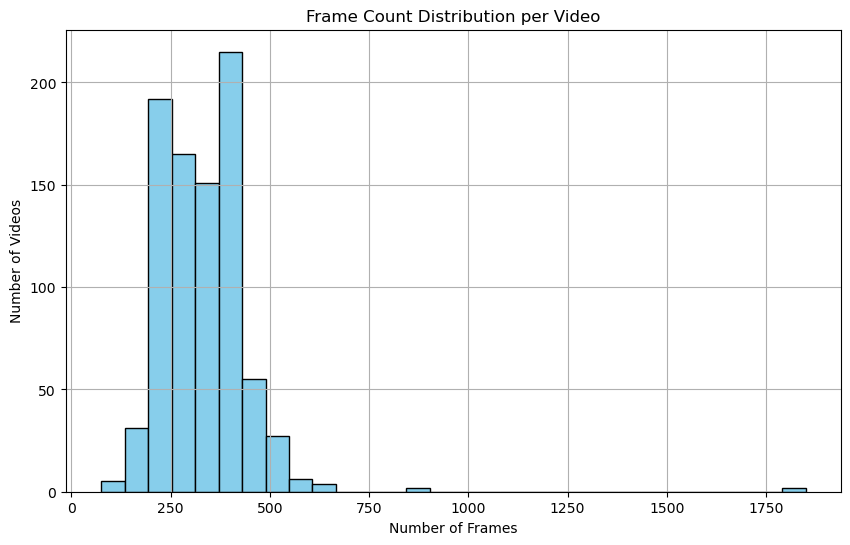

Statistics on video frame counts:
Min:    75
Max:    1850
Mean:   331.42
Median: 325.0
Std:    119.31


In [3]:
# Step 1: Count frames per video
def count_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return length

frame_counts = [count_frames(video) for video in tqdm(video_paths)]

# Step 2: Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(frame_counts, bins=30, color='skyblue', edgecolor='black')
plt.title("Frame Count Distribution per Video")
plt.xlabel("Number of Frames")
plt.ylabel("Number of Videos")
plt.grid(True)
plt.show()

# Step 3: Print statistics
print("Statistics on video frame counts:")
print(f"Min:    {np.min(frame_counts)}")
print(f"Max:    {np.max(frame_counts)}")
print(f"Mean:   {np.mean(frame_counts):.2f}")
print(f"Median: {np.median(frame_counts)}")
print(f"Std:    {np.std(frame_counts):.2f}")

## Note:  Decided to go with 96 frames per video

# Pose Detection

In [ ]:
import os
import cv2
import numpy as np
import mediapipe as mp
from tqdm import tqdm

# Define paths
VIDEO_DIR = "G:\Projects\Cellula_Internship\Shop_Lifting_Classification\Shop_DataSet"  # Your actual root folder
POSE_SAVE_DIR = "pose_arrays"
os.makedirs(POSE_SAVE_DIR, exist_ok=True)

# Setup Mediapipe
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Collect all videos from subdirectories
video_paths = []
for root, _, files in os.walk(VIDEO_DIR):
    for file in files:
        if file.lower().endswith(('.mp4', '.avi', '.mov', '.mkv', '.webm')):
            video_paths.append(os.path.join(root, file))

print(f"Found {len(video_paths)} videos.")

# Process each video
for idx, video_path in enumerate(tqdm(video_paths, desc="Extracting poses")):
    cap = cv2.VideoCapture(video_path)
    video_pose_data = []

    while True:
        success, frame = cap.read()
        if not success:
            break

        # Resize for speed (optional)
        frame = cv2.resize(frame, (256, 256))
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        results = pose.process(frame_rgb)

        if results.pose_landmarks:
            keypoints = []
            for lm in results.pose_landmarks.landmark:
                keypoints.append([lm.x, lm.y, lm.z, lm.visibility])
            video_pose_data.append(keypoints)
        else:
            # Append zeros if pose not detected
            video_pose_data.append(np.zeros((33, 4)))

    cap.release()

    video_pose_data = np.array(video_pose_data)
    if video_pose_data.shape[0] == 0:
        print(f"[WARNING] No frames in {video_path}, skipping.")
        continue

    # Save pose array
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    save_path = os.path.join(POSE_SAVE_DIR, f"{video_name}.npy")
    np.save(save_path, video_pose_data)

print("✅ Pose extraction completed.")

' import os\nimport cv2\nimport numpy as np\nimport mediapipe as mp\nfrom tqdm import tqdm\n\n# Define paths\nVIDEO_DIR = "G:\\Projects\\Cellula_Internship\\Shop_Lifting_Classification\\Shop_DataSet"  # Your actual root folder\nPOSE_SAVE_DIR = "pose_arrays"\nos.makedirs(POSE_SAVE_DIR, exist_ok=True)\n\n# Setup Mediapipe\nmp_pose = mp.solutions.pose\npose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)\n\n# Collect all videos from subdirectories\nvideo_paths = []\nfor root, _, files in os.walk(VIDEO_DIR):\n    for file in files:\n        if file.lower().endswith((\'.mp4\', \'.avi\', \'.mov\', \'.mkv\', \'.webm\')):\n            video_paths.append(os.path.join(root, file))\n\nprint(f"Found {len(video_paths)} videos.")\n\n# Process each video\nfor idx, video_path in enumerate(tqdm(video_paths, desc="Extracting poses")):\n    cap = cv2.VideoCapture(video_path)\n    video_pose_data = []\n\n    while True:\n        success, frame = cap.read(

# Pose array Preprocessing

In [5]:
import os
import numpy as np
from tqdm import tqdm

# Directories
POSE_ARRAY_DIR = r"pose_arrays"   # Folder where you stored the .npy pose arrays
SAVE_DIR = r"processed_pose_arrays"
EMPTY_SAVE_DIR = r"empty_pose_arrays"  # To store videos with no humans
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(EMPTY_SAVE_DIR, exist_ok=True)

# Parameters
TARGET_FRAMES = 96
KEYPOINTS = 33
DIMENSIONS = 2  # x, y only

# Processing
processed_count = 0
skipped_count = 0
empty_count = 0

for file in tqdm(os.listdir(POSE_ARRAY_DIR), desc="Processing poses"):
    if not file.endswith(".npy"):
        continue
    
    pose_seq = np.load(os.path.join(POSE_ARRAY_DIR, file))

    # Shape check
    if pose_seq.ndim != 3 or pose_seq.shape[1] != KEYPOINTS:
        skipped_count += 1
        continue  

    # Keep x, y only
    if pose_seq.shape[2] > DIMENSIONS:
        pose_seq = pose_seq[:, :, :DIMENSIONS]

    # If all frames are zeros → no human detected in video
    if np.all(pose_seq == 0):
        np.save(os.path.join(EMPTY_SAVE_DIR, file), pose_seq)
        empty_count += 1
        continue

print(f"✅ Pose post-processing completed.")
print(f"Processed: {processed_count}")
print(f"Empty/no-human: {empty_count}")
print(f"Skipped (corrupted): {skipped_count}")
print(f"Saved to: {SAVE_DIR}")
print(f"Empty videos saved to: {EMPTY_SAVE_DIR}")

Processing poses:   1%|▏         | 10/799 [00:00<00:07, 99.82it/s]

Processing poses: 100%|██████████| 799/799 [00:05<00:00, 137.05it/s]

✅ Pose post-processing completed.
Processed: 0
Empty/no-human: 431
Skipped (corrupted): 0
Saved to: processed_pose_arrays
Empty videos saved to: empty_pose_arrays


In [ ]:
import os
import numpy as np
from tqdm import tqdm

# Directories
POSE_ARRAY_DIR = r"pose_arrays"   # Folder where you stored the .npy pose arrays
SAVE_DIR = r"processed_pose_arrays"
EMPTY_SAVE_DIR = r"empty_pose_arrays"  # To store videos with no humans
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(EMPTY_SAVE_DIR, exist_ok=True)

# Parameters
TARGET_FRAMES = 96
KEYPOINTS = 33
DIMENSIONS = 2  # x, y only

def normalize_pose(pose):
    """
    Normalize a single frame of pose keypoints:
    1. Center at mid-hip
    2. Scale coordinates so max(abs(x), abs(y)) = 1
    """
    if np.all(pose == 0):
        return pose

    # 1. Center at hips
    mid_hip_x = (pose[23, 0] + pose[24, 0]) / 2
    mid_hip_y = (pose[23, 1] + pose[24, 1]) / 2
    pose[:, 0] -= mid_hip_x
    pose[:, 1] -= mid_hip_y

    # 2. Find global max absolute value (to handle very big/small coordinates)
    max_val = np.max(np.abs(pose))
    if max_val > 0:
        pose /= max_val  # now everything is in [-1, 1]

    return pose

def fill_missing_frames(seq):
    """
    Replace all-zero frames with the previous valid frame.
    """
    for i in range(len(seq)):
        if np.all(seq[i] == 0):
            if i > 0:
                seq[i] = seq[i-1]
            else:
                # If first frame is zero, find first non-zero
                non_zero_frames = seq[~np.all(seq == 0, axis=(1, 2))]
                if len(non_zero_frames) > 0:
                    seq[i] = non_zero_frames[0]
    return seq

def pad_or_trim_sequence(seq, target_len):
    if len(seq) > target_len:
        return seq[:target_len]
    elif len(seq) < target_len:
        pad_len = target_len - len(seq)
        padding = np.zeros((pad_len, KEYPOINTS, DIMENSIONS))
        return np.vstack([seq, padding])
    return seq

# Processing
processed_count = 0
skipped_count = 0
empty_count = 0

for file in tqdm(os.listdir(POSE_ARRAY_DIR), desc="Processing poses"):
    if not file.endswith(".npy"):
        continue
    
    pose_seq = np.load(os.path.join(POSE_ARRAY_DIR, file))

    # Shape check
    if pose_seq.ndim != 3 or pose_seq.shape[1] != KEYPOINTS:
        skipped_count += 1
        continue  

    # Keep x, y only
    if pose_seq.shape[2] > DIMENSIONS:
        pose_seq = pose_seq[:, :, :DIMENSIONS]

    # If all frames are zeros → no human detected in video
    if np.all(pose_seq == 0):
        np.save(os.path.join(EMPTY_SAVE_DIR, file), pose_seq)
        empty_count += 1
        continue

    # Fill missing frames
    pose_seq = fill_missing_frames(pose_seq)

    # Normalize
    pose_seq = np.array([normalize_pose(frame) for frame in pose_seq])

    # Pad/trim
    pose_seq = pad_or_trim_sequence(pose_seq, TARGET_FRAMES)

    # Save
    np.save(os.path.join(SAVE_DIR, file), pose_seq)
    processed_count += 1

print(f"✅ Pose post-processing completed.")
print(f"Processed: {processed_count}")
print(f"Empty/no-human: {empty_count}")
print(f"Skipped (corrupted): {skipped_count}")
print(f"Saved to: {SAVE_DIR}")
print(f"Empty videos saved to: {EMPTY_SAVE_DIR}")

Processing poses:   0%|          | 0/799 [00:00<?, ?it/s]

Processing poses:  21%|██        | 168/799 [00:03<00:12, 48.94it/s]

In [ ]:
import numpy as np
import os

min_val, max_val = float('inf'), float('-inf')
bad_shapes = []
empty_count = 0
nan_count = 0

for file in os.listdir(SAVE_DIR):
    if not file.endswith(".npy"):
        continue

    arr = np.load(os.path.join(SAVE_DIR, file))

    # Check shape
    if arr.shape != (TARGET_FRAMES, KEYPOINTS, DIMENSIONS):
        bad_shapes.append((file, arr.shape))
        continue

    # Track min/max
    min_val = min(min_val, arr.min())
    max_val = max(max_val, arr.max())

    # Count NaNs
    if np.isnan(arr).any():
        nan_count += 1

    # Count empty frames
    if np.all(arr == 0):
        empty_count += 1

print(f"✅ Shape OK for {len(os.listdir(SAVE_DIR)) - len(bad_shapes)} files")
if bad_shapes:
    print(f"❌ Bad shapes: {bad_shapes}")

print(f"📉 Min value: {min_val}")
print(f"📈 Max value: {max_val}")
print(f"🛑 NaN count: {nan_count}")
print(f"⚠️ Empty sequences: {empty_count}")

✅ Shape OK for 799 files
📉 Min value: -1.0
📈 Max value: 1.0
🛑 NaN count: 0
⚠️ Empty sequences: 431


# Match labels with preprocessed pose arrays

In [ ]:
import os
import pandas as pd

# Paths
RAW_SHOPLIFTERS = r"G:\Projects\Cellula_Internship\Shop_Lifting_Classification\Shop_DataSet\shop lifters"
RAW_NONSHOPLIFTERS = r"G:\Projects\Cellula_Internship\Shop_Lifting_Classification\Shop_DataSet\non shop lifters"
POSE_ARRAY_DIR = r"processed_pose_arrays"

# Step 1: Build mapping from raw data
label_map = {}
conflicts = []

# Shoplifters = label 1
for f in os.listdir(RAW_SHOPLIFTERS):
    if not f.lower().endswith(('.mp4', '.avi', '.mov')):
        continue
    name = os.path.splitext(f)[0]
    if name in label_map and label_map[name] != 1:
        conflicts.append(name)
    else:
        label_map[name] = 1

# Non-shoplifters = label 0
for f in os.listdir(RAW_NONSHOPLIFTERS):
    if not f.lower().endswith(('.mp4', '.avi', '.mov')):
        continue
    name = os.path.splitext(f)[0]
    if name in label_map and label_map[name] != 0:
        conflicts.append(name)
    else:
        label_map[name] = 0

conflicts = list(set(conflicts))
print(f"⚠ Found {len(conflicts)} filename conflicts: {conflicts}")

# Step 2: Match processed pose arrays to labels
records = []
skipped = 0

for f in os.listdir(POSE_ARRAY_DIR):
    if not f.endswith(".npy"):
        continue
    name = os.path.splitext(f)[0]  # without .npy
    if name in conflicts:
        skipped += 1
        continue
    if name in label_map:
        records.append((f, label_map[name]))
    else:
        skipped += 1

print(f"✅ Matched {len(records)} pose arrays to labels")
print(f"⏩ Skipped {skipped} files (conflicts or no label found)")

# Step 3: Save labels.csv
df = pd.DataFrame(records, columns=["filename", "label"])
df.to_csv("labels.csv", index=False)
print("💾 labels.csv saved successfully!")

⚠ Found 56 filename conflicts: ['videppppsss_5', 'videppppsss_12', 'videppppsss_6', 'videppppsss_0', 'videppppsss_20', 'videppppsss_10', 'videppppsss_44', 'videppppsss_15', 'videppppsss_33', 'videppppsss_45', 'videppppsss_34', 'videppppsss_8', 'videppppsss_37', 'videppppsss_1', 'videppppsss_9', 'videppppsss_29', 'videppppsss_24', 'videppppsss_41', 'videppppsss_11', 'videppppsss_13', 'videppppsss_43', 'videppppsss_21', 'videppppsss_40', 'videppppsss_4', 'videppppsss_16', 'videppppsss_25', 'videppppsss_36', 'videppppsss_38', 'videppppsss_42', 'videppppsss_53', 'videppppsss_32', 'videppppsss_54', 'videppppsss_26', 'videppppsss_3', 'videppppsss_47', 'videppppsss_31', 'videppppsss_7', 'videppppsss_52', 'videppppsss_18', 'videppppsss_2', 'videppppsss_14', 'videppppsss_55', 'videppppsss_46', 'videppppsss_51', 'videppppsss_22', 'videppppsss_50', 'videppppsss_19', 'videppppsss_30', 'videppppsss_48', 'videppppsss_23', 'videppppsss_39', 'videppppsss_28', 'videppppsss_17', 'videppppsss_27', 'videp

# Splitting the dataset

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Paths
POSE_ARRAY_DIR = r"processed_pose_arrays"
LABELS_CSV = r"labels.csv"

# Load labels
df = pd.read_csv(LABELS_CSV)

# Function to check if a sequence is empty
def is_empty_sequence(file_path):
    arr = np.load(file_path)
    return np.all(arr == 0)

# Remove empty sequences
mask = []
for idx, row in df.iterrows():
    file_path = os.path.join(POSE_ARRAY_DIR, row['filename'])
    if os.path.exists(file_path) and not is_empty_sequence(file_path):
        mask.append(True)
    else:
        mask.append(False)

df = df[mask].reset_index(drop=True)
print(f"✅ Non-empty sequences: {len(df)}")

# Stratified split
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df['label'], random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# Save splits
train_df.to_csv("train_labels.csv", index=False)
val_df.to_csv("val_labels.csv", index=False)
test_df.to_csv("test_labels.csv", index=False)

print("✅ Data split completed and saved.")

✅ Non-empty sequences: 347
Train: 242, Val: 52, Test: 53
✅ Data split completed and saved.


In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.utils.class_weight import compute_class_weight

# Paths to CSVs
TRAIN_LABELS = r"train_labels.csv"
VAL_LABELS   = r"val_labels.csv"
TEST_LABELS  = r"test_labels.csv"

# Folder where processed .npy pose arrays are saved
POSE_DIR = r"processed_pose_arrays"

# Function to load data
def load_data(labels_csv_path):
    df = pd.read_csv(labels_csv_path)
    X = []
    y = []

    for _, row in df.iterrows():
        filename = row['filename']  # column name in your labels.csv
        label = row['label']

        npy_path = os.path.join(POSE_DIR, filename)

        if not os.path.exists(npy_path):
            print(f"⚠️ Missing file: {npy_path}")
            continue

        pose_array = np.load(npy_path)
        X.append(pose_array)
        y.append(label)

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    return X, y

# Load each split
X_train, y_train = load_data(TRAIN_LABELS)
X_val,   y_val   = load_data(VAL_LABELS)
X_test,  y_test  = load_data(TEST_LABELS)

# === Compute class weights ===
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

""" y_train = y_train.astype(np.int32)
y_val   = y_val.astype(np.int32)
y_test  = y_test.astype(np.int32) """

print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

print("Train size:", len(X_train))
print("Val size:", len(X_val))
print("Test size:", len(X_test))

Class weights: {0: np.float64(0.7469135802469136), 1: np.float64(1.5125)}
Shapes:
X_train: (242, 96, 33, 2) y_train: (242,)
X_val: (52, 96, 33, 2) y_val: (52,)
X_test: (53, 96, 33, 2) y_test: (53,)
Train size: 242
Val size: 52
Test size: 53


# Model Architecture

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras import backend as K

SEQ_LEN = 96
KEYPOINTS = 33
DIMENSIONS = 2

# --- Model ---
# === Model Architecture ===
def build_model(seq_len, keypoints, dims):
    inputs = layers.Input(shape=(seq_len, keypoints, dims))

    # CNN feature extractor
    x = layers.TimeDistributed(layers.Conv1D(64, 3, activation='relu'))(inputs)
    x = layers.TimeDistributed(layers.MaxPooling1D(2))(x)
    x = layers.TimeDistributed(layers.Dropout(0.3))(x)

    x = layers.TimeDistributed(layers.Conv1D(128, 3, activation='relu'))(x)
    x = layers.TimeDistributed(layers.MaxPooling1D(2))(x)
    x = layers.TimeDistributed(layers.Dropout(0.3))(x)

    x = layers.TimeDistributed(layers.Flatten())(x)

    # BiLSTM
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=False, dropout=0.4, recurrent_dropout=0.3))(x)

    # Dense
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    return model

def f1_score(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.round(y_pred)
    tp = K.sum(y_true * y_pred)
    fp = K.sum((1.0 - y_true) * y_pred)
    fn = K.sum(y_true * (1.0 - y_pred))
    precision = tp / (tp + fp + K.epsilon())
    recall    = tp / (tp + fn + K.epsilon())
    return 2.0 * precision * recall / (precision + recall + K.epsilon())

model = build_pose_cnn_bilstm()

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        f1_score,
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
    ]
)

model.summary()

c:\Users\mazen\anaconda3\envs\teeth-cnn\lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_32             │ (None, 96, 31, 64)     │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_33             │ (None, 96, 15, 64)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_34             │ (None, 96, 15, 64)     │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_35             │ (None, 96, 960)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 256)            │     1,115,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,132,353 (4.32 MB)

 Trainable params: 1,132,225 (4.32 MB)

 Non-trainable params: 128 (512.00 B)

# Model Training

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
checkpoint_cb = ModelCheckpoint("best_pose_model.keras", save_best_only=True, monitor="val_f1_score", mode="max")

""" y_train = y_train.astype(np.int32)
y_val   = y_val.astype(np.int32)
y_test  = y_test.astype(np.int32) """

print("Train size:", len(X_train))
print("Val size:", len(X_val))
print("Test size:", len(X_test))

# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    callbacks=checkpoint_cb,
    class_weight=class_weights,
    verbose=1
)

Train size: 242
Val size: 52
Test size: 53
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.5226 - auc: 0.5522 - f1_score: 0.3597 - loss: 0.7799 - precision: 0.3452 - recall: 0.5249 - val_accuracy: 0.5769 - val_auc: 0.6176 - val_f1_score: 0.3383 - val_loss: 0.6530 - val_precision: 0.3684 - val_recall: 0.4118
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5950 - auc: 0.6517 - f1_score: 0.3259 - loss: 0.6423 - precision: 0.3582 - recall: 0.4517 - val_accuracy: 0.5769 - val_auc: 0.7269 - val_f1_score: 0.4395 - val_loss: 0.7209 - val_precision: 0.4242 - val_recall: 0.8235
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5349 - auc: 0.5782 - f1_score: 0.4046 - loss: 0.7410 - precision: 0.3845 - recall: 0.5951 - val_accuracy: 0.6538 - val_auc: 0.6277 - val_f1_score: 0.3484 - val_loss: 0.6862 - val_precision: 0.4762 - val_recall: 0.5882
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6596 - auc: 0.6815 - f1_score: 0.2938 - loss: 

# Model Evaluation

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
              precision    recall  f1-score   support

         0.0     0.8056    0.8286    0.8169        35
         1.0     0.6471    0.6111    0.6286        18

    accuracy                         0.7547        53
   macro avg     0.7263    0.7198    0.7227        53
weighted avg     0.7517    0.7547    0.7529        53



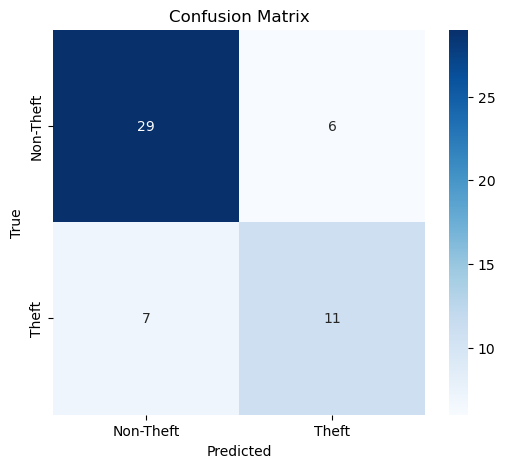

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Classification Report
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Theft", "Theft"], yticklabels=["Non-Theft", "Theft"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### Future Enchancements: Yolo + implementation + duplicate removal